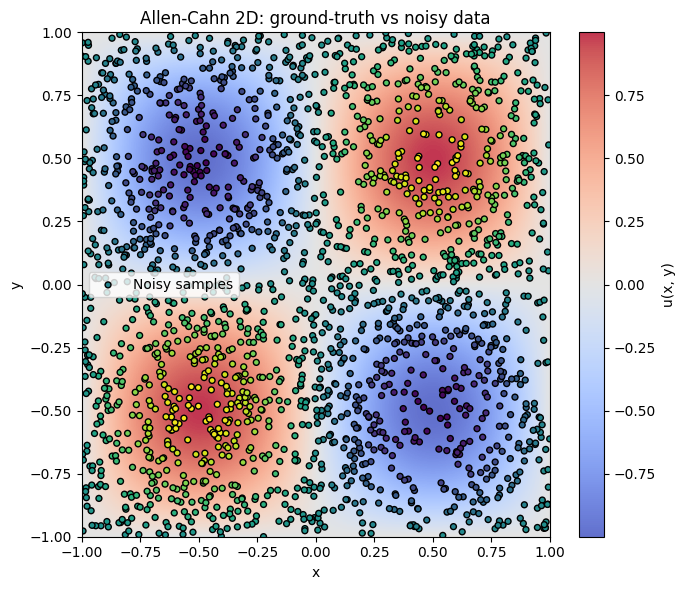

In [1]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. Imports & reproducibility
# ────────────────────────────────────────────────────────────────────────────────
import math, random, numpy as np, torch
from torch import nn

torch.set_num_threads(4)
seed = 12345
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ────────────────────────────────────────────────────────────────────────────────
# 1. Ground-truth PDE setup 
# ────────────────────────────────────────────────────────────────────────────────
from utils_pde.utils_pde_allencahn2d import AllenCahn2D

# 1) keep the torch-based definition
def true_solution(xy):
    return torch.sin(math.pi*xy[...,0:1]) * torch.sin(math.pi*xy[...,1:2])

domain=((-1.0, 1.0), (-1.0, 1.0))
pde = AllenCahn2D(lam=0.05, domain=domain, true_solution=true_solution)

# ────────────────────────────────────────────────────────────────────────────────
# 2. Data Generation (Noisy data for training, test, calibration)
# ────────────────────────────────────────────────────────────────────────────────
x_colloc_num = 1000  # Number of collocation points

data_noise = 0.01
N_train = 2000
N_test = 200
N_calib = 500
colloc_pt_num = 1000

X_train, Y_train = pde.data_generation(N_train, data_noise)
X_test, Y_test = pde.data_generation(N_test, data_noise)
X_calibration, Y_calibration = pde.data_generation(N_calib, data_noise)

alphas = torch.linspace(0.05, 0.99, 10)

# ────────────────────────────────────────────────────────────────────────────────
# 3. Visualization: Plot ground-truth & noisy data
# ────────────────────────────────────────────────────────────────────────────────
from utils_tools.utils_result_viz import plot_truth_and_samples_2D

# Dense grid for nice plotting
def make_dense_grid(domain, N=200):
    x = np.linspace(domain[0][0], domain[0][1], N)
    y = np.linspace(domain[1][0], domain[1][1], N)
    X, Y = np.meshgrid(x, y)
    XY_grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
    return XY_grid, X, Y

grid_test, X_mesh, Y_mesh = make_dense_grid(domain, 200)
grid_test_torch = torch.tensor(grid_test, dtype=torch.float32)
U_true_grid = true_solution(grid_test_torch).numpy().reshape(X_mesh.shape)


plot_truth_and_samples_2D(
    X_train, Y_train, grid_test, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
)


In [2]:
# Basic
import torch
import math
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
from numpy import random


# PDEi
from utils_pde.utils_pde_2dpoisson import Poisson2D

# Viz
from utils_tools.utils_result_viz import plot_predictions_2D

# Base Mdoels
from utils_uqmd.utils_uq_dropout import DropoutPINN
from utils_uqmd.utils_uq_mlp import MLPPINN
from utils_uqmd.utils_uq_vi import VIBPINN
from utils_uqmd.utils_uq_hmc import HMCBPINN

# CP
from utils_uqmd.utils_uq_cp import CP


# Model
hmc_model = HMCBPINN(
    pde_class=pde, input_dim=2, hidden_dims=[32, 64, 64, 64, 32],
    output_dim=1, act_func=nn.Tanh, prior_std=1.0,
    step_size=1e-3, leapfrog_steps=5
)

# Fitting args
fit_args = {
    "coloc_pt_num": colloc_pt_num,
    "X_train": X_train,
    "Y_train": Y_train
}
fit_kwargs_grid = {
    "λ_pde": [1.0],
    "λ_bc": [5.0],
    "λ_data": [5.0],
    "epochs": [2000],
    "lr": [1e-3],
    "hmc_samples": [8000],
    "burn_in":[3000],
    "step_size": [3e-4],
    "leapfrog_steps": [40],
}


baseline_pred_kwargs = { "n_samples": 5000 }
cp_pred_kwargs = {
    "X_train": X_train, "Y_train": Y_train,
    "X_cal": X_calibration, "Y_cal": Y_calibration,
    "heuristic_u": "raw_std", "k": 10
}
cp_coverage_args = {
    "alphas": alphas, "X_test": X_test, "Y_test": Y_test,
    "X_cal": X_calibration, "Y_cal": Y_calibration,
    "X_train": X_train, "Y_train": Y_train,
    "heuristic_u": "raw_std", "k": 10
}
baseline_coverage_args = {
    "uqmodel": hmc_model,
    "alphas": alphas,
    "X_test": X_test,
    "Y_test": Y_test,
    "n_samples": 5000
}


# --------------------------------------------
# Defining Plotting Grid
# --------------------------------------------
n_grid = 100
x = torch.linspace(domain[0][0],domain[0][1], n_grid)
y = torch.linspace(domain[1][0],domain[1][1], n_grid)
X, Y = torch.meshgrid(x, y, indexing='xy')
grid_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)


# --------------------------------------------
# Start hyperparameter tuning 
# --------------------------------------------
from utils_tools.utils_tuning import hyperparameter_tuning
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage
from utils_uqmd.utils_uq_cp import CP
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, hmc_test_uncertainties

hyperparameter_tuning(
    plot_title="HMC CP Model", # Change this
    # Model Fitting & Predicting
    uqmodel=hmc_model,  # Change this
    alpha=0.05, 
    X_test=grid_test, Y_test=Y_test, 
    fit_args=fit_args, fit_kwargs_grid=fit_kwargs_grid, baseline_pred_kwargs=baseline_pred_kwargs, cp_pred_kwargs=cp_pred_kwargs, 
    true_solution=pde.true_solution,
    # Coverage Test
    baseline_testing_args=baseline_coverage_args, cp_testing_args=cp_coverage_args,
    baseline_test_uncertainties=hmc_test_uncertainties, # Change this
    # Plotting function
    plotting_func=plot_2D_comparison_with_coverage, # Chang if dimension changes
    save_dir="2dallencahn_hmc_cp_p2", # Change this
    X_validation=X_test, Y_validation=Y_test,
)

Using device: cpu
Using device: cpu

[🔎] Trying: {'λ_pde': 1.0, 'λ_bc': 5.0, 'λ_data': 5.0, 'epochs': 2000, 'lr': 0.001, 'hmc_samples': 8000, 'burn_in': 3000, 'step_size': 0.0003, 'leapfrog_steps': 40}

[🟠] Training...


/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
MAP:  25%|██▌       | 509/2000 [00:05<00:16, 91.41it/s, loss=1.40e+00]

[MAP] epoch    500  −logPost=1.468e+00  Data=2.500e-01  PDE=5.104e-01  IC=0.000e+00  BC=2.508e-05


MAP:  50%|█████     | 1009/2000 [00:11<00:10, 91.43it/s, loss=8.01e-01]

[MAP] epoch   1000  −logPost=7.767e-01  Data=2.499e-01  PDE=4.969e-01  IC=0.000e+00  BC=4.397e-05


MAP:  76%|███████▌  | 1512/2000 [00:16<00:05, 92.57it/s, loss=7.48e-01]

[MAP] epoch   1500  −logPost=7.601e-01  Data=2.499e-01  PDE=5.097e-01  IC=0.000e+00  BC=5.236e-05


[MAP] epoch   2000  −logPost=7.749e-01  Data=2.500e-01  PDE=5.248e-01  IC=0.000e+00  BC=1.577e-05


HMC:   6%|▋         | 501/8000 [01:35<22:51,  5.47it/s, acc=0.97]

[HMC] iter    500  acc-rate=0.97


HMC:  13%|█▎        | 1001/8000 [03:10<22:05,  5.28it/s, acc=0.95]

[HMC] iter   1000  acc-rate=0.95


HMC:  19%|█▉        | 1500/8000 [04:50<22:22,  4.84it/s, acc=0.87]

[HMC] iter   1500  acc-rate=0.87


HMC:  25%|██▌       | 2000/8000 [06:32<21:16,  4.70it/s, acc=0.83]

[HMC] iter   2000  acc-rate=0.83


HMC:  31%|███▏      | 2501/8000 [08:15<18:17,  5.01it/s, acc=0.78]

[HMC] iter   2500  acc-rate=0.78


HMC:  38%|███▊      | 3000/8000 [09:56<15:50,  5.26it/s, acc=0.73]

[HMC] iter   3000  acc-rate=0.73


HMC:  44%|████▍     | 3501/8000 [11:23<11:57,  6.27it/s, acc=0.70]

[HMC] iter   3500  acc-rate=0.70


HMC:  50%|█████     | 4001/8000 [12:46<10:28,  6.36it/s, acc=0.68]

[HMC] iter   4000  acc-rate=0.68


HMC:  56%|█████▋    | 4501/8000 [14:24<11:25,  5.10it/s, acc=0.66]

[HMC] iter   4500  acc-rate=0.66


HMC:  63%|██████▎   | 5001/8000 [16:04<10:00,  4.99it/s, acc=0.66]

[HMC] iter   5000  acc-rate=0.66


HMC:  69%|██████▉   | 5500/8000 [17:56<09:03,  4.60it/s, acc=0.66]

[HMC] iter   5500  acc-rate=0.66


HMC:  75%|███████▌  | 6000/8000 [19:43<07:05,  4.70it/s, acc=0.65]

[HMC] iter   6000  acc-rate=0.65


HMC:  81%|████████▏ | 6500/8000 [21:29<05:31,  4.52it/s, acc=0.63]

[HMC] iter   6500  acc-rate=0.63


HMC:  88%|████████▊ | 7000/8000 [23:18<03:44,  4.45it/s, acc=0.62]

[HMC] iter   7000  acc-rate=0.62


HMC:  94%|█████████▍| 7500/8000 [25:12<01:53,  4.42it/s, acc=0.61]

[HMC] iter   7500  acc-rate=0.61


[HMC] iter   8000  acc-rate=0.60
Finished HMC: avg acceptance 0.604
Keep 5000 posterior sample from the HMC algo

[🟠] Base Model Inferencing...

[🟠] CP Model Inferencing...

[🟠] Computing Coverage...


100%|██████████| 10/10 [00:32<00:00,  3.27s/it]



[✅] Data Loss = 7.481e-01

[🏆] Best Hyperparameters: {'λ_pde': 1.0, 'λ_bc': 5.0, 'λ_data': 5.0, 'epochs': 2000, 'lr': 0.001, 'hmc_samples': 8000, 'burn_in': 3000, 'step_size': 0.0003, 'leapfrog_steps': 40} with Loss: 0.7481


{'λ_pde': 1.0,
 'λ_bc': 5.0,
 'λ_data': 5.0,
 'epochs': 2000,
 'lr': 0.001,
 'hmc_samples': 8000,
 'burn_in': 3000,
 'step_size': 0.0003,
 'leapfrog_steps': 40}

<Figure size 640x480 with 0 Axes>